In [1]:
import pandas as pd
from pandas.io import sql
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import dotenv
import seaborn as sns
import csv
import numpy as np

%matplotlib inline

In [2]:
%load_ext dotenv
%dotenv ../.env

In [3]:
cnx = create_engine(os.getenv('EDMDB'))

Get a count of records that have a lot area of zero

In [4]:
pd.read_sql_query('''
SELECT COUNT(*) AS lotarea_zero_count
FROM dcp.pluto192_before_corr
WHERE "LotArea" = 0;
''', cnx)

,lotarea_zero_count
0,2101


Create a breakout report by building class, with lotarea, shape_area, and the difference between them. Casting large numbers to integers for readability.

In [5]:
pd.read_sql_query('''
SELECT p1."BldgClass",
SUM(p1."LotArea") AS old_lotarea,
SUM(p2."LotArea") AS new_lotarea,
SUM(p2."LotArea" - p1."LotArea") AS difference
FROM dcp.pluto192_before_corr p1, dcp.pluto192 p2
WHERE p1."BBL" = p2."BBL"
GROUP BY p1."BldgClass"
ORDER BY p1."BldgClass";
''', cnx)

,BldgClass,old_lotarea,new_lotarea,difference
0,A0,37885163.0,37885163.0,0.0
1,A1,479167463.0,479169787.0,2324.0
2,A2,207612923.0,207612923.0,0.0
3,A3,64054396.0,64054396.0,0.0
4,A4,8556706.0,8556706.0,0.0
...,...,...,...,...
211,Z5,676101.0,676101.0,0.0
212,Z7,7250218.0,8871813.0,1621595.0
213,Z8,165608245.0,165608245.0,0.0
214,Z9,68507688.0,68513013.0,5325.0


Breakout report by land use code. Casting large numbers to integers for readability. Save as a dataframe for charting.

In [12]:
landuse_breakout = pd.read_sql_query('''
SELECT p1."LandUse",
d.def as "LandUse_Definition",
SUM(p1."LotArea") AS old_lotarea,
SUM(p2."LotArea") AS new_lotarea,
SUM(p2."LotArea" - p1."LotArea") AS difference
FROM dcp.pluto192_before_corr p1, dcp.pluto192 p2, dcp.landuse_definitions d
WHERE d.landuse = p1."LandUse"
AND p1."BBL" = p2."BBL"
GROUP BY p1."LandUse", d.def
ORDER BY (SUM(p2."Shape_Area"::numeric - ROUND(p1."LotArea"::numeric))) DESC;
''', cnx)
landuse_breakout

,LandUse,LandUse_Definition,old_lotarea,new_lotarea,difference
0,07,Transportation and Utility,490841651,642801254,151959603
1,01,One and Two Family Buildings,1827684793,1827689865,5072
2,02,Multi-Family Walkup Buildings,477401193,480964369,3563176
3,04,Mixed Residential and Commercial,246226680,249465963,3239283
4,05,Commercial and Office,272108523,272108523,0
5,03,Multi-Family Elevator Buildings,347675383,349259096,1583713
6,10,Parking Facilities,86054314,86066072,11758
7,06,Industrial and Manufacturing,228108881,228087155,-21726
8,08,Public Facilities and Institutions,534900031,534900031,0
9,11,Vacant Land,555829858,560153225,4323367


Breakout report by Borough. Casting large numbers to BIGINT.

In [7]:
pd.read_sql_query('''
SELECT p1."Borough",
SUM(p1."LotArea") AS old_lotarea,
SUM(p2."LotArea") AS new_lotarea,
SUM(p2."LotArea" - p1."LotArea") AS difference
FROM dcp.pluto192_before_corr p1, dcp.pluto192 p2
WHERE p1."BBL" = p2."BBL"
GROUP BY p1."Borough"
ORDER BY p1."Borough";
''', cnx)

,Borough,old_lotarea,new_lotarea,difference
0,BK,1663660298,1695070502,31410204
1,BX,911762872,941058914,29296042
2,MN,494219347,501251201,7031854
3,QN,2364371325,2440730188,76358863
4,SI,1322005773,1344478806,22473033


Overall totals

In [8]:
pd.read_sql_query('''
SELECT SUM(p1."LotArea") AS old_lotarea,
SUM(p2."LotArea") AS new_lotarea,
SUM(p2."LotArea" - p1."LotArea") AS difference
FROM dcp.pluto192_before_corr p1, dcp.pluto192 p2
WHERE p1."BBL" = p2."BBL";
''', cnx)

,old_lotarea,new_lotarea,difference
0,6756019615,6922589611,166569996


Settings for bar chart

In [37]:
sns.set()

SMALL_SIZE = 8
MEDIUM_SMALL_SIZE = 10
MEDIUM_SIZE = 12
MEDIUM_LARGE_SIZE = 14
BIGGER_SIZE = 16

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Inconsolata']
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Bar chart by landuse code

In [ ]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = round(int(tick_val) /1000000000, 1)
        return '{}B'.format(val)
    elif tick_val > 1000000:
        val = round(int(tick_val) /1000000)
        return '{}M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{}k'.format(val)
    else:
        return tick_val

landuse = []
lotarea = []
old_lotarea = []
new_lotarea = []

for ind in landuse_breakout.index: 
    landuse.append(landuse_breakout['LandUse

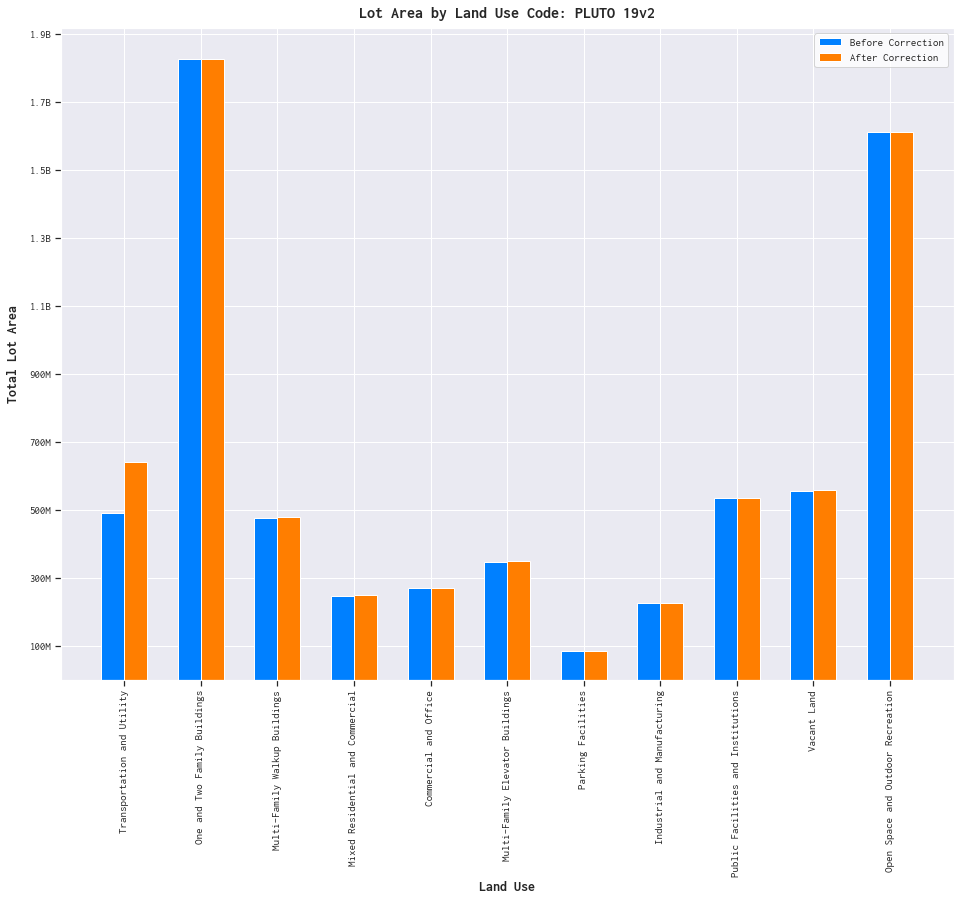

In [33]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = round(int(tick_val) /1000000000, 1)
        return '{}B'.format(val)
    elif tick_val > 1000000:
        val = round(int(tick_val) /1000000)
        return '{}M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{}k'.format(val)
    else:
        return tick_val

landuse = []
lotarea = []
old_lotarea = []
new_lotarea = []

for ind in landuse_breakout.index: 
    landuse.append(landuse_breakout['LandUse_Definition'][ind])
    old_lotarea.append(int(landuse_breakout['old_lotarea'][ind]))
    new_lotarea.append(int(landuse_breakout['new_lotarea'][ind]))

width = 0.3
r1 = np.arange(len(landuse))

f = plt.figure(figsize=(16,12))
ax = f.add_subplot(111)
ax.bar(r1, old_lotarea, width, color='#0080ff', align='center', label='Before Correction')
ax.bar(r1+width, new_lotarea, width, color='#ff7e00', align='center', label='After Correction')
ax.ticklabel_format(useOffset=False, style='plain')
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

plt.xlabel('Land Use', fontweight='bold')
plt.ylabel('Total Lot Area', fontweight='bold', labelpad=10)
plt.title('Lot Area by Land Use Code: PLUTO 19v2', fontweight='bold', pad=10)
plt.tick_params(bottom=True, left=True)
plt.xticks(rotation=90)
plt.xticks(r1 + width / 2, landuse)
plt.yticks(np.arange(100000000, 2000000000, 200000000))
plt.legend(loc='upper right', shadow='bool')
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [34]:
def x_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = round(int(tick_val) /1000000000, 1)
        return '{}B'.format(val)
    elif tick_val > 1000000:
        val = round(int(tick_val) /1000000)
        return '{}M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{}k'.format(val)
    else:
        return tick_val

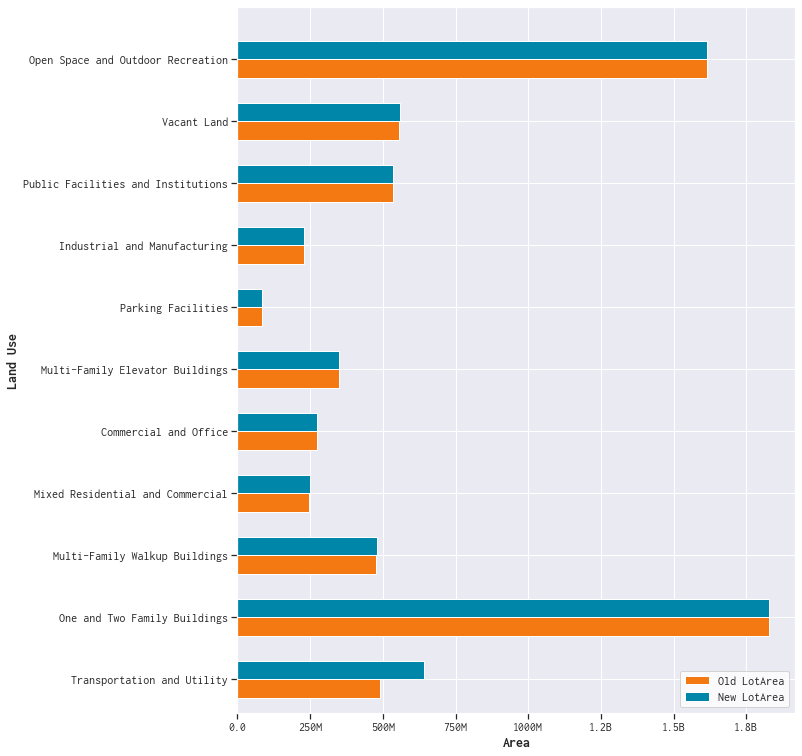

In [39]:
lotarea = landuse_breakout['old_lotarea'].to_list()
shapearea = landuse_breakout['new_lotarea'].to_list()
landuse = landuse_breakout['LandUse_Definition'].to_list()
df = pd.DataFrame(dict(graph=landuse,
                           n=lotarea, m=shapearea)) 

ind = np.arange(len(df))
width = 0.3

fig, ax = plt.subplots(figsize=(10,13))
ax.barh(ind, df.n, width, color='#f47912', label='Old LotArea')
ax.barh(ind + width, df.m, width, color='#0086a8', label='New LotArea')

ax.set(yticks=ind + width/2, yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Land Use", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
#plt.title('LotArea v. LotArea Replaced by Shape_Area', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()